# 1.5 Introdução a Redes Neurais: minha primeira Rede Neural em JAX :D

Vamos codar nossa primeira rede neural que de fato aprende com exemplos. Para isso vamos começar resolvendo o problema de regressão e classificação com bases de dados simples e fictícias para então resolver uma base de dados real.


#### Dependências

In [1]:
# Gráficos
import matplotlib.pyplot as plt

# Matemática + manipulação de vetores
import math
import numpy as np

# JAX
import jax
from jax import nn
import jax.numpy as jnp

# # "Fixar" números aleatórios a serem gerados
np.random.seed(0)

# Trabalhar com os dados
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Utilidades
import utils

# Recarregar automaticamente dependências caso elas mudem
%load_ext autoreload
%autoreload 2

### Gerando dados sintéticos

$Y = 7 * X + 15$

In [2]:
# número de dados sintéticos gerados
SYNT_TRAIN_SIZE = 200

# controla o quão espalhados são os dados
STD_DEV = 0.7

def random_error(size, mu=0, std_dev=0.5):
    return np.random.normal(mu, std_dev, size)

def add_batch_dim(tensor):
    if len(tensor.shape) == 1:
        return jnp.expand_dims(tensor, axis=1)
    else:
        return tensor

def remove_batch_dim(tensor):
    return jnp.squeeze(tensor, axis=1)
    
def generate_x(size, use_batch_dim=True):
    x = np.random.rand(size)
    if use_batch_dim:
        x = add_batch_dim(x)
    return x

def plot_line(x, y, style='-b'):
    x, y = remove_batch_dim(x), remove_batch_dim(y)
    return plt.plot([min(x), max(x)], [min(y), max(y)], style)

def generate_f(x, a=7, b=15, error_std_dev=0.5, use_batch_dim=True):
    y = a * x + b + random_error(x.shape, std_dev=error_std_dev)
    if use_batch_dim:
        y = add_batch_dim(y)
    return y
def identity(x):
    return x

# gera valores aleatórios para x
synt_x = generate_x(SYNT_TRAIN_SIZE)

# gera a funcão: Y = 7 * X + 15
synt_y = generate_f(synt_x, error_std_dev=STD_DEV)

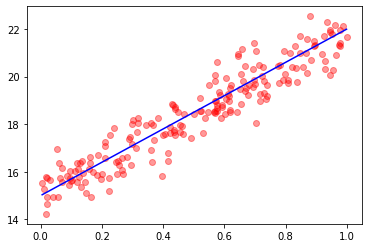

In [3]:
plt.plot(synt_x, synt_y, 'ro', alpha=0.4)
plot_line(synt_x, synt_x * 7 + 15)
plt.show()

### Implementando Rede Neural

In [24]:
def define_params(sizes=[1, 1]):
    '''He-et-all initialization'''
    weights = []
    for i, (in_dim, out_dim) in enumerate(zip(sizes[:-1], sizes[1:])):
        weights.append({"w": np.random.randn(in_dim, out_dim) * np.sqrt(2/in_dim), 
                        "b": np.random.randn(out_dim) * np.sqrt(2/in_dim)})           
    
    return weights


def apply_fn(weights, batch_x, activations):
    output = batch_x
    for layer, act_fn in zip(weights, activations):
        output = jnp.dot(output, layer["w"]) + layer["b"]
        output = act_fn(output)
    return output

def l2_loss(weights, batch_x, real_y, activations):
    pred_y = apply_fn(weights, batch_x, activations)
    return 0.5 * np.mean((pred_y - real_y)**2)

### Implementando SGD

In [5]:
def train_step(weights, batch_x, batch_y, activations, loss_fn=l2_loss):
    loss, grads = jax.value_and_grad(loss_fn)(weights, batch_x, batch_y, activations)
    weights = jax.tree_util.tree_multimap(lambda v, g: v - g, weights, grads)
    return weights, loss

def evaluate(self, batch_x, batch_y, metrics=[]):
    # run feed forward network
    pred_y = self.model.run_batch(batch_x)
    # loss
    loss = self.loss(pred_y, batch_y)
    self.eval_losses.append(loss)
    # metrics
    res_metrics = []
    for m in metrics:
        if m in self._metrics:
            res_metrics.append(self._metrics[m](pred_y, batch_y))
        else:
            raise ValueError('Invalid metric: %s' % m)
        
    self.eval_steps.append(self.train_step)
            
    return loss, res_metrics

def plot_losses(train_losses, eval_losses, step):
    if len(eval_losses) > 0:
        plt.title('Train Loss: %.4f | Test Loss: %.4f for step %d' % (train_losses[-1], eval_losses[-1], step))
    else:
        plt.title('Train Loss: %.4f for step %d' % (train_losses[-1], step))    
    plt.plot([i for i in range(step)], train_losses)
    plt.plot([i for i in eval_steps], eval_losses)




### Gradients

##### L2 loss with 1 layer, no activation

**Loss**

$$L = 1/2 * 1/n * \sum{(y_i - ŷ_i)^{2}}$$
$$L = 1/2 * 1/n * \sum{(y_i - w_i * x_i + b_i)^{2}}$$

**Gradients**

$$\frac{\partial L}{\partial w_i} = 1/2 * 1/n * 2 * \sum{(y_i - ŷ_i)} * \frac{\partial {ŷ_i}}{\partial w_i} $$
$$\frac{\partial L}{\partial w_i} = 1/n * \sum{(y_i - ŷ_i)} * x_i$$

---

$$\frac{\partial L}{\partial b_i} = 1/2 * 1/n * 2 * \sum{(y_i - ŷ_i)} * \frac{\partial {ŷ_i}}{\partial b_i} $$
$$\frac{\partial L}{\partial b_i} = 1/n * \sum{(y_i - ŷ_i)} * 1$$


##### L2 loss with 2 layers, relu activation in the hidden layer

**Loss**

$$L = 1/2 * 1/n * \sum{(y_i - ŷ_i)^{2}}$$
$$L = 1/2 * 1/n * \sum{(y_i - (w_j * x_j + b_j))^{2}}$$
$$x_j = relu(w_i * x_i + b_i)$$


**Gradients**

$$\frac{\partial L}{\partial w_i} = 1/n * \sum{(y_i - ŷ_i)} * x_j $$
$$\frac{\partial L}{\partial b_i} = 1/n * \sum{(y_i - ŷ_i)} * 1$$

$$\frac{\partial L}{\partial w_j} = 1/n * \sum{(y_i - ŷ_i)} * x_j * x_i, se relu() > 0$$
$$\frac{\partial L}{\partial b_j} = 1/n * \sum{(y_i - ŷ_i)} * x_j, se relu() > 0$$

### Treinando

In [6]:
neural_net = define_params()
for i in range(1000):
    neural_net, loss = train_step(neural_net, synt_x, synt_y, [identity])
    if i % 100 == 0:
        print(loss)
        
# # t.plot_losses()

211.88776
0.22370072
0.22370064
0.22370064
0.22370064
0.22370064
0.22370064
0.22370064
0.22370064
0.22370064


#### Comparando com a realidade

Parâmetros aprendidos:
pesos: [[6.6933656]]
bias: [15.074862]
Função que modela os dados: 7 * X + 15


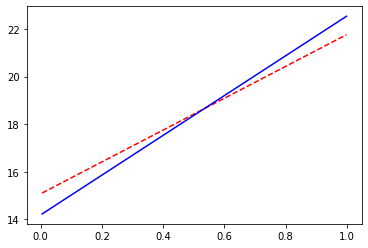

In [24]:
print('Parâmetros aprendidos:')
print('pesos:', neural_net[0]["w"])
print('bias:', neural_net[0]["b"])
print('Função que modela os dados: 7 * X + 15')
plot_line(synt_x, apply_fn(neural_net, synt_x, [identity]), '--r')
plot_line(synt_x, synt_y)
plt.show()

### Uma função um pouco mais complicada

$Y = 7 * log(x) + 1$


In [7]:
def get_random_error(size, mu=0, std_dev=0.8):
    return np.random.normal(mu, std_dev, size)

synt_x = np.random.rand(SYNT_TRAIN_SIZE)
synt_y = jnp.reshape(7 * np.log(synt_x) + 1 + get_random_error(SYNT_TRAIN_SIZE), (SYNT_TRAIN_SIZE, 1))

synt_x = jnp.reshape(synt_x, (SYNT_TRAIN_SIZE, 1))

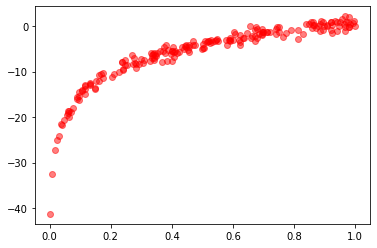

In [8]:
plt.plot(synt_x, synt_y, 'ro', alpha=0.5)

In [16]:
nn = define_params(sizes=[1, 10, 1])
activations=[jax.nn.sigmoid, identity]

In [26]:
for i in range(1000):
    nn, loss = train_step(nn, synt_x, synt_y, activations)

# plot_losses()

Parâmetros aprendidos:
pesos: [DeviceArray([[ -7.455005  , -16.347853  ,  -0.84756553,  -6.447151  ,
               -7.4279637 , -12.303604  , -10.097615  , -10.148254  ,
              -12.364756  , -46.429806  ]], dtype=float32), DeviceArray([[  9.721085  ],
             [ -8.911329  ],
             [  9.445306  ],
             [  0.22159743],
             [  5.3888206 ],
             [  6.3215    ],
             [ -3.930574  ],
             [  8.168222  ],
             [  6.166117  ],
             [-17.844713  ]], dtype=float32)]
bias: [DeviceArray([ -8.674239 ,   7.2597938,  -9.923597 ,  -6.6514344,
             -14.212091 , -15.800454 ,   1.234818 , -13.057161 ,
             -16.256367 ,   3.3652153], dtype=float32), DeviceArray([-2.0572762], dtype=float32)]
Função que modela os dados: 7 * X + 15


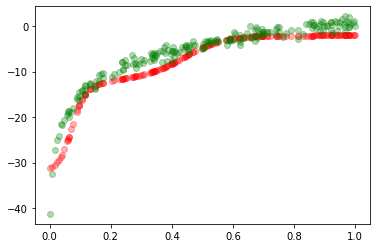

In [27]:
print('Parâmetros aprendidos:')
print('pesos:', [weight["w"] for weight in nn])
print('bias:', [weight["b"] for weight in nn])
print('Função que modela os dados: 7 * X + 15')
plt.plot(synt_x, apply_fn(nn, synt_x, activations), 'or', alpha=0.3)
plt.plot(synt_x, synt_y, 'og', alpha=0.3)
plt.show()

### E se os dados forem não lineares?

In [44]:
xor_x = jnp.array([[0, 0], [0, 1], [1, 0], [1, 1]])
xor_y = jnp.array([[0], [1], [1], [0]])

In [51]:
activations=[jax.nn.relu, identity]
nn = define_params(sizes=[2, 10, 2])
for i in range(1000):
    nn, loss = train_step(nn, xor_x, xor_y, activations)
    if i % 100 == 0:
        print(apply_fn(nn, xor_x, activations))
        print(loss)

# plot_losses()

[[ -3.375266     0.79805183]
 [-10.314086     2.9373302 ]
 [ -0.876618     0.7105523 ]
 [ -7.9580593    2.4523752 ]]
0.7018602
[[ 0.02091762 -0.0087807 ]
 [ 0.99853873  0.99898255]
 [ 1.0011417   0.996643  ]
 [-0.01650289  0.01685387]]
7.0809765e-05
[[ 0.00297777 -0.00129701]
 [ 0.99983203  0.9997932 ]
 [ 1.0003508   0.9994863 ]
 [-0.00265829  0.00257718]]
1.6057588e-06
[[ 4.7342398e-04 -2.0657014e-04]
 [ 9.9997783e-01  9.9997115e-01]
 [ 1.0000566e+00  9.9991620e-01]
 [-4.2956800e-04  4.0727179e-04]]
4.0798703e-08
[[ 7.5866352e-05 -3.3181394e-05]
 [ 9.9999642e-01  9.9999535e-01]
 [ 1.0000092e+00  9.9998665e-01]
 [-6.8939276e-05  6.5284548e-05]]
1.0489044e-09
[[ 1.2221091e-05 -5.2489340e-06]
 [ 9.9999946e-01  9.9999923e-01]
 [ 1.0000014e+00  9.9999785e-01]
 [-1.1099764e-05  1.0502525e-05]]
2.7121461e-11
[[ 2.1337328e-06 -7.8068115e-07]
 [ 9.9999988e-01  9.9999982e-01]
 [ 1.0000002e+00  9.9999964e-01]
 [-1.9787258e-06  1.5420374e-06]]
7.608461e-13
[[ 5.8795558e-07 -5.0989911e-08]
 [ 9.99

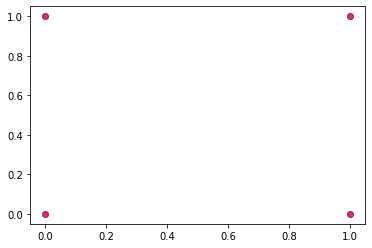

In [50]:
plt.plot(xor_x, apply_fn(nn, xor_x, activations), 'bo', xor_x, xor_y, 'ro', alpha=0.3)

In [53]:
activations=[identity, identity]
nn = define_params(sizes=[2, 10, 2])
for i in range(1000):
    nn, loss = train_step(nn, xor_x, xor_y, activations)

# plot_losses()

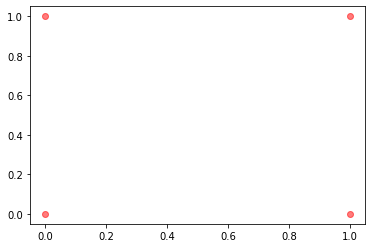

In [54]:
plt.plot(xor_x, apply_fn(nn, xor_x, activations), 'bo', xor_x, xor_y, 'ro', alpha=0.3)

### Exemplo: [base dados Iris](https://mari-linhares.github.io/codando-deep-learning/notebooks/glossario.html#iris)

Digamos que para um exemplo da base de dados queremos determinar qual a espécie dessa planta.

**Entradas**

A base de dados iris tem 4 **[atributos](https://mari-linhares.github.io/codando-deep-learning/notebooks/glossario.html#atributos)** de uma planta que iremos usar como entrada.

**Saídas**

Neste caso a saída que nos interessa é a espécie da planta. Então digamos que a saída é um número que indica qual a espécie:

0 = Iris Setosa , 1 = Iris Versicolour, 2 = Iris Virginica

### Obtendo os dados

In [55]:
# Carregar base de dados iris
iris = fetch_openml('iris')

# np.c_ concatena as features e targets do dataset
iris_data = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                         columns=['x0', 'x1', 'x2', 'x3', 'target'])

/home/joaogui/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/datasets/_openml.py:407: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


In [56]:
iris_data.head()

,x0,x1,x2,x3,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [57]:
iris_data.describe()

,x0,x1,x2,x3,target
count,150.0,150.0,150.0,150.0,150
unique,35.0,23.0,43.0,22.0,3
top,5.0,3.0,1.5,0.2,Iris-setosa
freq,10.0,26.0,14.0,28.0,50


In [58]:
iris_data.drop(['target'], axis=1).diff().hist(color='k', alpha=0.5, bins=10, figsize=(4, 5))
plt.show()

ValueError: hist method requires numerical or datetime columns, nothing to plot.

In [31]:
x = iris.data
y = iris.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [32]:
def batches(x, y, batch_size=True):
    idx = np.random.permutation(len(x))
    x = x[idx]
    y = y[idx]
    
    for i in range(0, len(x)-batch_size-1, batch_size):
        batch_x = x[i:i+batch_size]
        batch_y = y[i:i+batch_size]
        yield batch_x, batch_y

Test loss = 1.21398, accuracy 0.44737
Test loss = 1.19670, accuracy 0.52632
Test loss = 1.20644, accuracy 0.55263
Test loss = 1.20227, accuracy 0.55263
Test loss = 1.17978, accuracy 0.55263
Test loss = 1.12980, accuracy 0.55263
Test loss = 1.04272, accuracy 0.52632
Test loss = 0.90289, accuracy 0.63158
Test loss = 0.72344, accuracy 0.94737
Test loss = 0.57425, accuracy 0.94737
Test loss = 0.48888, accuracy 0.94737
Test loss = 0.44399, accuracy 0.94737
Test loss = 0.42637, accuracy 0.94737
Test loss = 0.41667, accuracy 0.94737
Test loss = 0.40954, accuracy 0.94737
Test loss = 0.40582, accuracy 0.94737
Test loss = 0.40292, accuracy 0.94737
Test loss = 0.39989, accuracy 0.94737
Test loss = 0.40108, accuracy 0.94737
Test loss = 0.40485, accuracy 0.92105
Test loss = 0.40582, accuracy 0.92105
Test loss = 0.40479, accuracy 0.92105
Test loss = 0.40645, accuracy 0.92105
Test loss = 0.40586, accuracy 0.92105
Test loss = 0.40694, accuracy 0.92105
Test loss = 0.40653, accuracy 0.92105
Test loss = 

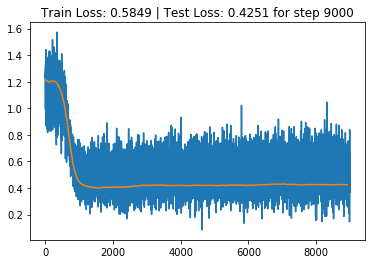

In [33]:
nn = NeuralNetwork(layers=[10, 4], input_size=4, activations=['relu', None])
t = Trainer(nn, verbose=False, loss_name='cross-entropy')
for i in range(1000):
    for batch_x, batch_y in batches(x, y, 16):
        t.train(batch_x, batch_y)
    if i % 10 == 0:
        loss, metrics = t.eval(x_test, y_test, metrics=['accuracy'])
        print('Test loss = %.5f, accuracy %.5f' % (loss, metrics[0]))

t.plot_losses()

### MNIIST

In [ ]:
# load mnist
mnist = fetch_mldata('MNIST original')

In [ ]:
x = mnist.data / np.max(mnist.data)
y = mnist.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
nn = NeuralNetwork(layers=[512, 256, 10], input_size=784, activations=['relu', 'relu', None])
t = Trainer(nn, verbose=False, loss_name='cross-entropy', learning_rate=0.001)
for i in range(20):
    for batch_x, batch_y in batches(x, y, 64):
        t.train(batch_x, batch_y)
    if i % 1 == 0:
        loss, metrics = t.eval(x_test, y_test, metrics=['accuracy'])
        print('Test loss = %.5f, accuracy %.5f' % (loss, metrics[0]))

t.plot_losses()

## Em busca da função perfeita


### Exemplo: [base dados Iris](https://mari-linhares.github.io/codando-deep-learning/notebooks/glossario.html#iris)

Digamos que para um exemplo da base de dados queremos determinar qual a espécie dessa planta.

**Entradas**

A base de dados iris tem 4 **[atributos](https://mari-linhares.github.io/codando-deep-learning/notebooks/glossario.html#atributos)** de uma planta que iremos usar como entrada.

**Saídas**

Neste caso a saída que nos interessa é a espécie da planta. Então digamos que a saída é um número que indica qual a espécie:

0 = Iris Setosa , 1 = Iris Versicolour, 2 = Iris Virginica

### Obtendo a base de dados

In [ ]:
# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

# Trabalhar com os dados
from sklearn.datasets import fetch_mldata

# Atributos: iris_dataset.data
# Espécie: iris_dataset.target
iris_dataset = fetch_mldata('iris')

print('Numero de exemplos na base:', len(iris_dataset.data))
print('Atributos da primeira planta:', iris_dataset.data[0])
print('Especie da primeira planta:', iris_dataset.target[0])

### Vamos codar uma função que resolve esse problema!

Uma função para resolver esse problema precisa receber 4 parâmetros (cada um dos atributos da planta) e produzir uma saída (espécie da planta).


In [ ]:
def f(x1, x2, x3, x4):
    # Não importa os atributos pra mim a resposta é sempre: Setosa!!!!
    return 0

print(f(*iris_dataset.data[0]), iris_dataset.target[0])
print(f(*iris_dataset.data[1]), iris_dataset.target[1])
print(f(*iris_dataset.data[-1]), iris_dataset.target[-1])

A função acima é válida para este problema (4 entradas, 1 saída), o problema dela é que... Ela não ta ajudando a gente no nosso problema em nada! Ela simplesmente ignora os atributos e nos diz que qualquer exemplo é da espécie Setosa.

Como podemos avaliar o quão boa é essa função? Uma métrica possível é [acurácia](https://mari-linhares.github.io/codando-deep-learning/notebooks/glossario.html#acuracia)


Por exemplo: dado um banco com a altura de determinadas pessoas (entrada), queremos estimar o "peso" dessas pessoas. Nesse caso, o "peso" das pessoas é a variável que queremos estimar. Portanto, o "peso" nesse caso representaria a nossa saída. Sempre que a nossa saída é conhecida, nós dizemos que esse tipo de problema é um problema de **Aprendizagem Supervisionada**.Há casos em que não necessariamente o nosso problema tem uma saída explícita. Nesse caso, teremos uma **Aprendizagem Não-Supervisionada**.

Além disso, quando a **saída assume qualquer valor real** (0, 1.2, 3.14, -26, +34, ...), nós dizemos que temos um **Problema de Regressão**. Por outro lado, quando a **saída é discreta** (0/1, saudável/doente, cachorro/gato/passarinho), nós temos **Problemas de Classificação**.



A grande sacada é o que acontece dentro de `f`! A ideia é que não sabemos qual o melhor `f` possível, e poderíamos tentar várias funções para se **ajustar** aos dados.

Em geral, elas são matrizes $NxD$, onde $N$ (#linhas) **representa o número de amostras** que seu banco de dados tem e $D$ (#colunas) **representa a quantidade de atributos** de cada amostra, também conhecida por *dimensionalidade*. Como exemplo, imagine que tenhamos um banco de dados com 1.000 amostras e cada amostra tem 5 atributos. Logo, nossas entradas seriam representadas por uma matriz $1000x5$, sacou? 




As entradas são representadas pelas amostras dos seus dados. Em geral, elas são matrizes $NxD$, onde $N$ (#linhas) **representa o número de amostras** que seu banco de dados tem e $D$ (#colunas) **representa a quantidade de atributos** de cada amostra, também conhecida por *dimensionalidade*. Como exemplo, imagine que tenhamos um banco de dados com 1.000 amostras e cada amostra tem 5 atributos. Logo, nossas entradas seriam representadas por uma matriz $1000x5$, sacou? 

**As saídas, por sua vez, representam o que você quer que a sua rede aprenda**. Por exemplo: dado um banco com a altura de determinadas pessoas (entrada), queremos estimar o "peso" dessas pessoas. Nesse caso, o "peso" das pessoas é a variável que queremos estimar. Portanto, o "peso" nesse caso representaria a nossa saída. Sempre que a nossa saída é conhecida, nós dizemos que esse tipo de problema é um problema de **Aprendizagem Supervisionada**. Há casos em que não necessariamente o nosso problema tem uma saída explícita. Nesse caso, teremos uma **Aprendizagem Não-Supervisionada**. Além disso, quando a **saída assume qualquer valor real** (0, 1.2, 3.14, -26, +34, ...), nós dizemos que temos um **Problema de Regressão**. Por outro lado, quando a **saída é discreta** (0/1, homem/mulher, cachorro/gato/passarinho), nós temos **Problemas de Classificação**.